In [1]:
import pandas as pd

In [2]:
# 读取训练集将图片分类好的csv文件
df=pd.read_csv('sample_submission_file.csv',engine='python')
df.head()

,Category,Id
0,cbsd,test-img-0.jpg
1,cmd,test-img-1.jpg
2,cbb,test-img-2.jpg
3,cmd,test-img-3.jpg
4,cbsd,test-img-4.jpg


In [3]:
# 查看训练集木薯疾病种类，以及具有该疾病的数量
df.Category.value_counts()

cmd        800
healthy    784
cbb        753
cbsd       731
cgm        706
Name: Category, dtype: int64

In [4]:
# 查看是否有缺失值
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 2 columns):
Category    3774 non-null object
Id          3774 non-null object
dtypes: object(2)
memory usage: 59.0+ KB


In [6]:
IMAGE_HT_WID=96
BATCH_SIZE = 70 #100 

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
# 定义训练集图片批量生成器，对图片进行预处理
train_datagen = ImageDataGenerator(
                              #  featurewise_center=True,
                               # featurewise_std_normalization= True,
                              #  zca_whitening = False,
                                rotation_range=8,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               #data_format='channels_last',
                              channel_shift_range = 0.1,
                              fill_mode='nearest',
                              brightness_range=[0.5, 1.5],
                               validation_split=0.25,
                               rescale=1./255)

In [7]:
# 定义测试集集图片批量生成器，对图片进行预处理
test_datagen = ImageDataGenerator(rescale=1./255)

# 对训练集进行图片预处理
train_gen=train_datagen.flow_from_directory(
                    directory="train/",
                    subset="training",
                    batch_size=BATCH_SIZE,
                    seed=42,
                    shuffle=True,
                    class_mode='categorical',
                    target_size=(IMAGE_HT_WID,IMAGE_HT_WID))

# 对验证集进行图片预处理
valid_gen=train_datagen.flow_from_directory(
                    directory="train/",
                    subset="validation",
                    batch_size=BATCH_SIZE,
                    seed=42,
                    shuffle=True,
                    class_mode='categorical',
                    target_size=(IMAGE_HT_WID,IMAGE_HT_WID))

Found 4244 images belonging to 5 classes.
Found 1412 images belonging to 5 classes.


In [8]:
import tensorflow as tf
keras=tf.keras

# 加载预训练模型MobileNetV2为基本模型
base_model = keras.applications.MobileNetV2(
             input_shape=(IMAGE_HT_WID, IMAGE_HT_WID, 3),
             include_top=False, 
             weights='imagenet')

# 保留原始模型的权重参数，进行迁移学习
base_model.trainable = False

# 定义顺序模型
model = keras.Sequential([
  base_model,
# 正则化层
  keras.layers.GaussianNoise(0.2), 
# 进行全局平均池化
  keras.layers.GlobalAveragePooling2D(),
# 全连接层
  keras.layers.Dense(5, activation='sigmoid')
])

# 定义反向传播
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.0001), metrics=['accuracy'])
print('layers长度：',len(base_model.layers))
print(base_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
layers长度： 155
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 48, 48, 32)   128         Conv1[0][0]                      
_______________________

In [9]:
# 自动降低learning rate
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, 
                                                                    patience=3, verbose=2, mode='auto',
                                                                    min_lr=1e-6)

# 定义early stoping如果3个epoch内val_loss没有改善则提前停止训练
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            # min_delta=0, 
                                             patience=6, verbose=2, mode='auto',
                                             baseline=None, restore_best_weights=True)

In [10]:
# 定义训练模型的迭代总轮数
EPOCHS= 10

# 定义批次样本数
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size + 1
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size + 1

print(train_gen.n)
print(train_gen.batch_size)
print(STEP_SIZE_TRAIN)
print(valid_gen.n)
print(valid_gen.batch_size)
print(STEP_SIZE_VALID)

# 记录模型
history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    verbose=2,
                    callbacks=[reduce_lr, early_stop],
                    initial_epoch=0
)

# 模型得分
score=model.evaluate_generator(generator=train_gen)[1]
print(score)

4244
70
61
1412
70
21
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
21/21 [==============================] - 28s 1s/step - loss: 0.5367 - acc: 0.7766
 - 125s - loss: 0.6125 - acc: 0.6828 - val_loss: 0.5367 - val_acc: 0.7766
Epoch 2/10
21/21 [==============================] - 20s 951ms/step - loss: 0.5134 - acc: 0.7901
 - 90s - loss: 0.4665 - acc: 0.7987 - val_loss: 0.5134 - val_acc: 0.7901
Epoch 3/10
21/21 [==============================] - 21s 979ms/step - loss: 0.4923 - acc: 0.7904
 - 91s - loss: 0.4366 - acc: 0.8115 - val_loss: 0.4923 - val_acc: 0.7904
Epoch 4/10
21/21 [==============================] - 21s 985ms/step - loss: 0.4680 - acc: 0.8061
 - 94s - loss: 0.4163 - acc: 0.8239 - val_loss: 0.4680 - val_acc: 0.8061
Epoch 5/10
21/21 [==============================] - 21s 997ms/step - loss: 0.4529 - acc: 0.8101
 - 94s - loss: 0.4075 - acc: 0.8282 - val_loss: 0.4529 - val_acc: 0.8101
Epoch 6/10
21/21 [==============================] - 21s 1s/step - loss: 0.4424 - acc: 0

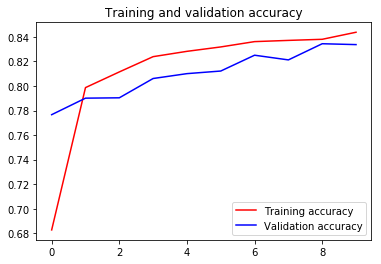

<Figure size 432x288 with 0 Axes>

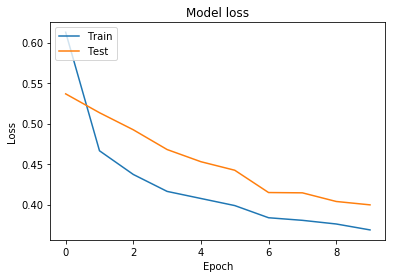

In [12]:
import matplotlib.pyplot as plt

# 绘制训练 & 验证的准确率值
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
#定义测试集图片生成器，对测试集进行图片预处理
test_generator=test_datagen.flow_from_directory(
                directory="test/",
                batch_size=BATCH_SIZE,
                seed=42,
                shuffle=False,
                class_mode=None,
                target_size=(IMAGE_HT_WID,IMAGE_HT_WID))

Found 3774 images belonging to 1 classes.


In [14]:
# 定义批次样本数
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size + 1
print(test_generator.n)
print(test_generator.batch_size)
print(STEP_SIZE_TEST)

# 因为用到了两个生成器，所以需要对生成器进行初始化
test_generator.reset()

# 预测测试集
pred=model.predict_generator(test_generator,
                steps=STEP_SIZE_TEST,
                verbose=1)


3774
70
54
54/54 [==============================] - 61s 1s/step


In [15]:
print(pred.shape)

(3774, 5)


In [17]:
import numpy as np

# 将得到的预测数据转为pandas的DataFrame数据
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Category":predictions,
                      "id":filenames})
print(results.head())
print(results.Category.value_counts())

  Category                   id
0     cbsd     0\test-img-0.jpg
1     cbsd     0\test-img-1.jpg
2      cmd    0\test-img-10.jpg
3      cmd   0\test-img-100.jpg
4     cbsd  0\test-img-1000.jpg
cmd        1894
cbsd       1596
cgm         200
healthy      74
cbb          10
Name: Category, dtype: int64


In [18]:
#再将pandas的DataFrame数据生成csv文件
results.to_csv(path_or_buf='predict.csv')